In [ ]:
# pip install subword-nmt seaborn lifelines openpyxl matplotlib scikit-learn openTSNE
# pip install torchmetrics==1.2.0 pandas==2.1.4 numpy==1.26.4
# python3 ./main_kfold.py --config utils/config.py
import torch.nn as nn
from utils.Loss import Custom_LossFunction,Custom_Weighted_LossFunction,FocalLoss
from utils.Custom_Activation_Function import ScaledSigmoid, ReLU_clamp
from utils.Metrics import MetricsCalculator_nntorch
                  
model_inference = True # False
if model_inference is True:
    cohort = "TCGA"
    geneNUM = "_4692genes" # _4692genes tcgadata tcgalabel tcgadata_4692genes tcgalabel_4692genes

test = False #False, True: batch_size = 3, num_epoch = 2, full dataset
drug_df_path= "../data/TransCDR/214drug SMILES MACCS AllZero.csv"
AUC_df_path_numerical = "../data/TransCDR/Iorio LNic50 611ccl 214drug threshold numerical matrix from GDSC(ModelID).csv" # gdsc1+2_ccle_z-score　gdsc1+2_ccle_AUC
AUC_df_path = "../data/TransCDR/Iorio LNic50 611ccl 214drug threshold binary matrix from GDSC(ModelID) balanced.csv"
omics_files = {
    'Mut': "",
    'Exp': "../data/TransCDR/EXP_611ccl_4692_genes.csv", # "../data/CCLE/CCLE_exp_476samples_4692genes.txt",
    # Add more omics types and paths as needed
    }
omics_dict = {'Mut':0,'Exp':1,'CN':2, 'Eff':3, 'Dep':4, 'Met':5}
omics_data_dict = {}
omics_data_tensor_dict = {}
omics_numfeatures_dict = {}
omics_encode_dim_dict ={'Mut':[1000,100,50],'Exp':[1000,100,50],  # Dr.Chiu:exp[500,200,50] [1000,100,50]
                        'CN':[100,50,30], 'Eff':[100,50,30], 'Dep':[100,50,30], 'Met':[100,50,30]}

TCGA_pretrain_weight_path_dict = {'Mut': "./results/Encoder_tcga_mut_1000_100_50_best_loss_0.0066.pt",
                                  'Exp': "./results/Encoder_tcga_exp_1000_100_50_best_loss_0.7.pt",
                                  # Add more omics types and paths as needed
                                }
seed = 42
#hyperparameter
model_name = "Omics_DrugESPF_Model" # Omics_DrugESPF_Model  Omics_DCSA_Model
AUCtransform = None #"-log2"
splitType= 'byCCL' # byCCL byDrug
kfoldCV = 5
include_omics = ['Exp']
DA_Folder = None
deconfound_EXPembedding = False # False True
if deconfound_EXPembedding is True:
    DA_Folder = "VAE_w10SC" #VAE_w10SC
    omics_files['Exp'] = f"../data/DAPL/share/pretrain/{DA_Folder}/ccle_latent_results.pkl" #
max_drug_len=50 # 不夠補零補到50 / 超過取前50個subwords(index) !!!!須改方法!!!! 
drug_embedding_feature_size = 128
ESPF = False # False True
Drug_SelfAttention = False
n_layer = 1 # transformer layer number
pos_emb_type = 'sinusoidal' # 'learned' 'sinusoidal'
#需再修改-----------

intermediate_size =256
num_attention_heads = 8        
attention_probs_dropout_prob = 0.1
hidden_dropout_prob = 0.1

if ESPF is True:
    drug_encode_dims =[1600,400,100] # 50*128  
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][2] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
elif ESPF is False:
    drug_encode_dims =[110,55,22]
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][2] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
if model_name == "Omics_DCSA_Model":
    drug_encode_dims =[(max_drug_len+len(include_omics))*(drug_embedding_feature_size+num_attention_heads)+ (len(include_omics)*128), 700, 70, 1] #
    dense_layer_dim = None
print("drug_encode_dims",drug_encode_dims)
print("dense_layer_dim",dense_layer_dim)
#需再修改-------------
TrackGradient = False # False True

activation_func = nn.ReLU()  # ReLU activation function # Leaky ReLu
activation_func_final = nn.Sigmoid() # ScaledSigmoid(scale=8) GroundT range ( 0 ~ scale ) # ReLU_clamp(max=8)
#nn.Sigmoid()or ReLU() or Linear/identity(when -log2AUC)
batch_size = 200
num_epoch = 200 # for k fold CV 
patience = 20
learning_rate=1e-05

warmup_lr = True # False True
decrese_epoch = 60
Decrease_percent = 1
continuous = True

CosineAnnealing_LR = False # False True
T_max = 3 # CosinesAnnealingLR step size
eta_min = 1e-06 # CosinesAnnealingLR minimum learning rate

criterion = Custom_Weighted_LossFunction(loss_type="weighted_BCE", loss_lambda=1.0, regular_type=None, regular_lambda=1e-06) #nn.MSELoss()#
# criterion =  FocalLoss(loss_type="MSE", alpha=8.0, gamma=1.0, regular_type=None, regular_lambda=1e-05) # loss_type="MSE"/"MAE"
# criterion = FocalHuberLoss(loss_type="FocalHuberLoss",delta=0.2, alpha=0.3, gamma=2.0, regular_type=None, regular_lambda=1e-05)
if 'BCE' in criterion.loss_type : 
    metrics_type_set = ["Accuracy","AUROC", "AUPRC", "Sensitivity","Specificity", "Precision", "F1", "F1_RecSpe", "F1_RecSpePre" ] 
    metric="F1_RecSpe" # best_prob_threshold_metric
    best_prob_threshold=0.5
else:
    metrics_type_set = ["MSE", "R^2"] #"MSE","MAE"  None
    metric=None # best_prob_threshold_metric
    best_prob_threshold=None
metrics_calculator = MetricsCalculator_nntorch(types = metrics_type_set)
""" A customizable loss function class.
    Args:
        loss_type (str): The type of loss to use ("RMSE", "MSE", "MAE","BCE","MAE+BCE", "MAE+MSE", "MAE+RMSE")/("weighted_RMSE", "weighted_MSE", "weighted_MAE", "weighted_MAE+MSE", "weighted_MAE+RMSE").
        loss_lambda (float): The lambda weight for the additional loss (MSE or RMSE) if applicable. Default is MAE+ 1.0*(MSE or RMSE).
        regular_type (str): The type of regularization to use ("L1", "L2", "L1+L2"), or None for no regularization.
        regular_lambda (float): The lambda weight for regularization. Default is 1e-05.
        
        # Binary Cross Entropy Loss # already done sigmoid"""
hyperparameter_print = f'  metric ={metric}\n best_prob_threshold ={best_prob_threshold}\n cohort ={cohort}\n geneNUM={geneNUM}\n drug_df_path ={drug_df_path}\n AUC_df_path_numerical ={AUC_df_path_numerical}\n AUC_df_path ={AUC_df_path}\n omics_dict ={omics_dict}\n omics_files ={omics_files}\n TCGA_pretrain_weight_path_dict ={TCGA_pretrain_weight_path_dict}\n seed ={seed}\n  model_name ={model_name}\n AUCtransform ={AUCtransform}\n splitType ={splitType}\n kfoldCV ={kfoldCV}\n omics_encode_dim ={[(omic_type,omics_encode_dim_dict[omic_type]) for omic_type in include_omics]}\n deconfound_EXPembedding ={deconfound_EXPembedding}\n DA_Folder ={DA_Folder}\n max_drug_len ={max_drug_len}\n drug_embedding_feature_size ={drug_embedding_feature_size}\n ESPF ={ESPF}\n Drug_SelfAttention ={Drug_SelfAttention}\n n_layer ={n_layer}\n pos_emb_type ={pos_emb_type}\n intermediate_size ={intermediate_size}\n num_attention_heads ={num_attention_heads}\n attention_probs_dropout_prob ={attention_probs_dropout_prob}\n hidden_dropout_prob ={hidden_dropout_prob}\n drug_encode_dims ={drug_encode_dims}\n dense_layer_dim = {dense_layer_dim}\n activation_func = {activation_func}\n activation_func_final = {activation_func_final}\n batch_size = {batch_size}\n num_epoch = {num_epoch}\n patience = {patience}\n decrese_epoch = {decrese_epoch}\n Decrease_percent = {Decrease_percent}\n continuous ={continuous}\n learning_rate = {learning_rate}\n criterion ={criterion}\n'

__translation_table__ = str.maketrans({
    "*": "",    "/": "",    ":": "-",    "%": "",
    "'": "",    "\"": "",    "[": "",    "]": "",
    ",": "" })

hyperparameter_folder_part = (f"{model_name}_{splitType}_ESPF{ESPF}_DrugSelfAtten{Drug_SelfAttention}").translate(__translation_table__)

if test is True:
    print("Running in test mode, using small batch size and few epochs for quick testing.")
    batch_size = 10
    num_epoch = 2
    kfoldCV = 2


drug_encode_dims [110, 55, 22]
dense_layer_dim 72
Running in test mode, using small batch size and few epochs for quick testing.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import math
import copy
import numpy as np

def create_mlpEncoder(dimList, activation_func):
    layers = []
    for i in range(len(dimList) - 1):  
        layers.append(nn.Linear(dimList[i], dimList[i + 1]))
        if i < len(dimList) - 2:  
            layers.append(activation_func)        
    return nn.Sequential(*layers)

# Models------------------------------------------------------------------------------------------------------------------------------------------------------
class Omics_DrugESPF_Model(nn.Module):
    def __init__(self,omics_encode_dim_dict,drug_encode_dims, activation_func,activation_func_final,dense_layer_dim, device, ESPF, Drug_SelfAttention,
                 pos_emb_type, hidden_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,n_layer,deconfound_EXPembedding, TCGA_pretrain_weight_path_dict=None):
        super(Omics_DrugESPF_Model, self).__init__()
        self.n_layer = n_layer

        if deconfound_EXPembedding is True:
            self.MLP4omics_dict = nn.ModuleDict()
            for omic_type in omics_numfeatures_dict.keys():
                self.MLP4omics_dict[omic_type] = nn.Sequential(
                    nn.Identity()  # just pass through the input, no linear combination no transformation
                )
        else:    
            def load_TCGA_pretrain_weight(model, pretrained_weights_path, device):
                state_dict = torch.load(pretrained_weights_path, map_location=device)  # Load the state_dict
                encoder_state_dict = {key[len("encoder."):]: value for key, value in state_dict.items() if key.startswith('encoder')}  # Extract encoder weights
                model.load_state_dict(encoder_state_dict)  # Load only the encoder part
                model_keys = set(model.state_dict().keys())  # Check if the keys match
                loaded_keys = set(encoder_state_dict.keys())
                if model_keys == loaded_keys:
                    print(f"State_dict for {model} loaded successfully.")
                else:
                    print(f"State_dict does not match the model's architecture for {model}.")
                    print("Model keys: ", model_keys, " Loaded keys: ", loaded_keys)

    # Create subnetworks for each omic type dynamically
            self.MLP4omics_dict = nn.ModuleDict()
            for omic_type in omics_numfeatures_dict.keys():
                self.MLP4omics_dict[omic_type] = create_mlpEncoder([omics_numfeatures_dict[omic_type]] + omics_encode_dim_dict[omic_type], activation_func
                )
                # Initialize with TCGA pretrain weight
                if TCGA_pretrain_weight_path_dict is not None:
                    load_TCGA_pretrain_weight(self.MLP4omics_dict[omic_type], TCGA_pretrain_weight_path_dict[omic_type], device)
                else: # Initialize weights with Kaiming uniform initialization, bias with aero
                    self._init_weights(self.MLP4omics_dict[omic_type])
  
# Define the final prediction network 
        self.model_final_add = nn.Sequential(
            nn.Linear(50, 50),
            activation_func,
            nn.Dropout(p=0),
            nn.Linear(50, 50), 
            activation_func,
            nn.Dropout(p=0),
            nn.Linear(50, 1),
            activation_func_final)
        # Initialize weights with Kaiming uniform initialization, bias with aero
        self._init_weights(self.model_final_add)

        self.print_flag = True
        self.attention_probs = None # store Attention score matrix
       
    def _init_weights(self, model):
        if isinstance(model, nn.Linear):  # 直接初始化 nn.Linear 層
            init.kaiming_uniform_(model.weight, a=0, mode='fan_in', nonlinearity='relu')
            if model.bias is not None:
                init.zeros_(model.bias)
        elif isinstance(model, nn.LayerNorm):
            init.ones_(model.weight)
            init.zeros_(model.bias)
        elif isinstance(model, nn.ModuleList) or isinstance(model, nn.Sequential):  # 遍歷子層
            for layer in model:
                self._init_weights(layer)
    def forward(self, omics_tensor_dict,drug, device,**kwargs):
        omic_embeddings = []
        # Loop through each omic type and pass through its respective model
        for omic_type, omic_tensor in omics_tensor_dict.items():
            omic_embed = self.MLP4omics_dict[omic_type](omic_tensor)#.to(device=device)
            omic_embeddings.append(omic_embed)
        omic_embeddings = torch.cat(omic_embeddings, dim=1)  # change list to tensor, because omic_embeddings need to be tensor to torch.cat([omic_embeddings, drug_emb_masked], dim=1) 

        
        # Concatenate embeddings from all subnetworks
        output_before_final_activation = self.model_final_add[:-1](omic_embeddings)
        output = self.model_final_add[-1](output_before_final_activation)
        return output, self.attention_probs,'',output_before_final_activation

In [ ]:
# train.py
from tracemalloc import start
import torch
import copy
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import time 
from torch.optim.lr_scheduler import CosineAnnealingLR
class GradientNormTracker:
    def __init__(self, batch_size,check_frequency=10, enable_plot=True):
        self.check_frequency = check_frequency
        self.enable_plot = enable_plot
        self.gradient_norms = []  # Store gradient norms for plotting
        self.steps = 0  # Track the number of steps or epochs
        self.gradient_fig = None
        self.batch_size = batch_size
    def check_and_log(self, model):
        total_norm = 0.0
        self.steps += 1
        if self.steps % self.check_frequency == 0:
            total_norm = torch.sqrt(torch.sum(torch.stack([param.grad.data.norm(2) ** 2 for param in model.parameters() if param.grad is not None])))
            self.gradient_norms.append(total_norm)
            # print(f"Step {self.steps}: Total Gradient Norm = {total_norm:.4f}")
        return self.gradient_norms
    def plot_gradient_norms(self):
        step_interval = self.batch_size//2  # Set the interval for plotting
        if self.enable_plot:    
            self.gradient_fig = plt.figure(figsize=(16, 6))
            gradient_norms_cpu = [gn.cpu().item() if isinstance(gn, torch.Tensor) else gn 
                          for gn in self.gradient_norms[::step_interval]]
            plt.plot(range(1, len(self.gradient_norms) + 1, step_interval), gradient_norms_cpu, marker='o', linestyle='-')
            plt.title("Gradient Norms Over Time")
            plt.xlabel("Step")
            plt.ylabel("Gradient Norm")
            plt.grid()
        elif self.enable_plot is False:
            self.gradient_fig = None   
        return self.gradient_fig
def warmup_lr_scheduler(optimizer, decrese_epoch, Decrease_percent,continuous=True):
    def f(epoch):
        if epoch >= decrese_epoch:
            if continuous is True:
                return Decrease_percent ** (epoch-decrese_epoch+1)
            elif continuous is not True:
                return Decrease_percent
        return 1
    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)
def log_gradient_norms(model):
    total_norm = 0.0
    for param in model.parameters():
        if param.grad is not None:  # Skip parameters without gradients
            param_norm = param.grad.data.norm(2)  # L2 norm (Euclidean distance)# sum(ei^2)^0.5
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    print(f"Total Gradient Norm: {total_norm:.4f}")
    return total_norm
def evaluation(model, eval_epoch_loss_W_penalty_ls, eval_epoch_loss_WO_penalty_ls, 
               criterion, eval_loader, device,ESPF,Drug_SelfAttention, 
               weighted_threshold, few_weight, more_weight, 
               outputcontrol='' ):
    torch.manual_seed(42)
    eval_outputs = [] # for correlation
    eval_targets = [] # for correlation
    eval_outputs_before_final_activation_list = []
    predAUCwithUnknownGT = []
    mean_batch_eval_loss_W_penalty = None #np.float32(0.0)
    mean_batch_eval_loss_WO_penalty= None #np.float32(0.0)
    model.eval()
    model.requires_grad = False
    weight_loss_mask = None
    with torch.no_grad():
        for inputs in eval_loader:
            omics_tensor_dict,drug, target = inputs[0],inputs[1], inputs[-1]#.to(device=device)
            model_output = model(omics_tensor_dict, drug, device, **{"ESPF":ESPF,"Drug_SelfAttention":Drug_SelfAttention}) #drug.to(torch.float32)
            outputs = model_output[0]  # model_output[1] # model_output[2] # output.shape(n_sample, 1)
            mask = ~torch.isnan(target)# Create a mask for non-NaN values in tensor # 去除nan的項 # mask.shape(n_sample, 1)
            target = target[mask]# Apply the mask to filter out NaN values from both tensors # target.shape(n_sample, 1)->(n_sample-nan, 1)
            
            predAUCwithUnknownGT.append(outputs.detach().cpu().numpy().reshape(-1))# for unknown GroundTruth
            outputs = outputs[mask] #dtype = 'float32'
            
            eval_outputs.append(outputs.detach().reshape(-1)) #dtype = 'float32' # [tensor]
            eval_targets.append(target.detach().reshape(-1)) # [tensor]
            if outputcontrol != 'plotLossCurve':
                eval_outputs_before_final_activation_list.append((model_output[3])[mask].detach().cpu().numpy().reshape(-1))
            if 'weighted' in criterion.loss_type :    
                if 'BCE' in criterion.loss_type :
                    weight_loss_mask = torch.where(torch.cat(eval_targets) == 1, few_weight, more_weight) # 手動對正樣本給 few_weight 倍權重，負樣本給 more_weight 倍                        
                else:
                    weight_loss_mask = torch.where(torch.cat(eval_targets) > weighted_threshold, few_weight, more_weight)
        
        mean_batch_eval_loss_W_penalty = criterion(torch.cat(eval_outputs),torch.cat(eval_targets), model, weight_loss_mask)# with weighted loss # without batch effect the loss
        mean_batch_eval_loss_WO_penalty = criterion.loss_WO_penalty.cpu().detach().numpy()

        # just for evaluation in train epoch loop , and plot the epochs loss, not for correlation
        if outputcontrol =='plotLossCurve': 
            # print(f'Epoch [{epoch + 1}/{num_epoch}] - mean_batch Validation Loss: {mean_batch_eval_loss:.8f}')
            eval_epoch_loss_W_penalty_ls.append(mean_batch_eval_loss_W_penalty.cpu().detach().numpy() )# 
            eval_epoch_loss_WO_penalty_ls.append(mean_batch_eval_loss_WO_penalty )
            return (eval_targets, eval_outputs,
                    eval_epoch_loss_W_penalty_ls,  eval_epoch_loss_WO_penalty_ls,  
                    mean_batch_eval_loss_WO_penalty)
        # for inference after train epoch loop, and store output for correlation
        elif outputcontrol == 'correlation':
            # print(f'Evaluation {outputcontrol} Loss: {mean_batch_eval_loss:.8f}')
            return (eval_targets, eval_outputs,mean_batch_eval_loss_WO_penalty,
                    eval_outputs_before_final_activation_list)
        elif outputcontrol =='inference':
            AttenScorMat_DrugSelf = model_output[1]
            AttenScorMat_DrugCellSelf = model_output[2]
            return (eval_targets, eval_outputs,predAUCwithUnknownGT, 
                    AttenScorMat_DrugSelf,AttenScorMat_DrugCellSelf,
                    eval_outputs_before_final_activation_list, mean_batch_eval_loss_WO_penalty)
        else:
            print('error occur when outputcontrol argument is not correct')
            return 'error occur when outputcontrol argument is not correct'
def train(model, optimizer, 
          criterion, train_loader, val_loader, device,
          ESPF,Drug_SelfAttention,seed,
          weighted_threshold, few_weight, more_weight, TrackGradient=False):
    
    # Training with early stopping (assuming you've defined the EarlyStopping logic)
    if warmup_lr is True:
        lr_scheduler = warmup_lr_scheduler(optimizer, decrese_epoch, Decrease_percent,continuous)
    if CosineAnnealing_LR is True:
        lr_scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
    if TrackGradient is True:
        Grad_tracker = GradientNormTracker(batch_size,check_frequency=10, enable_plot=True)  # Enable or disable plotting
    BE_val_loss_WO_penalty = float('inf')
    BE_val_train_loss_WO_penalty = None
    best_weight=None
    counter = 0
    val_epoch_loss_W_penalty_ls = []
    val_epoch_loss_WO_penalty_ls = [] # for validation every epoch loss plot
    train_epoch_loss_W_penalty_ls = []
    train_epoch_loss_WO_penalty_ls = []
    torch.manual_seed(seed)
    model.train()
    model.requires_grad = True
    for epoch in range(num_epoch):
        batch_idx_without_nan_count=0 # if a batch has [] empty list than don't count
        weight_loss_mask = None
        for batch_idx,inputs in enumerate(train_loader):
            optimizer.zero_grad()
            omics_tensor_dict,drug = inputs[0],inputs[1]
            target = inputs[2]#.to(device=device)
            
            model_output = model(omics_tensor_dict, drug, device,**{"ESPF":ESPF,"Drug_SelfAttention":Drug_SelfAttention}) #drug.to(torch.float32)
            outputs =model_output[0]
            # attention_score_matrix torch.Size([bsz, 8, 50, 50])# softmax(without dropout)
            mask = ~torch.isnan(target)# Create a mask for non-NaN values in tensor # 0:nan, 1:non-nan
            target = target[mask]# Apply the mask to filter out NaN values from both tensors # 去除nan的項 [nan, 0.7908]->[0.7908]
            outputs = outputs[mask]

            if target.numel() != 0: # 確保batch中target去除掉nan後還有數值 (count)
                batch_idx_without_nan_count+=1# if 這個batch有數值batch才累加 
                if 'weighted' in criterion.loss_type :    
                    if 'BCE' in criterion.loss_type :
                        weight_loss_mask = torch.where(target == 1, few_weight, more_weight) # 手動對正樣本給 few_weight 倍權重，負樣本給 more_weight 倍                        
                    else:
                        weight_loss_mask = torch.where(target > weighted_threshold, few_weight, more_weight)
                loss = criterion(outputs.reshape(-1), target.to(torch.float32).reshape(-1), model, weight_loss_mask)
                # assert loss.requires_grad == True  # Ensure gradients are being computed
                loss.backward()  # Compute gradients
                if TrackGradient is True:
                    gradient_norms_list = Grad_tracker.check_and_log(model)  # Check and log gradient norms
                else:
                    gradient_norms_list = None
                #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Apply gradient clipping
                optimizer.step()  # Update weights

        (val_targets, val_outputs,
         val_epoch_loss_W_penalty_ls,  val_epoch_loss_WO_penalty_ls, 
         mean_batch_val_loss_WO_penalty) = evaluation(model, 
                                                    val_epoch_loss_W_penalty_ls, val_epoch_loss_WO_penalty_ls, 
                                                    criterion, val_loader, device, ESPF, Drug_SelfAttention, 
                                                    weighted_threshold, few_weight, more_weight, 
                                                    outputcontrol='plotLossCurve') 
        (train_targets, train_outputs,
         train_epoch_loss_W_penalty_ls,  train_epoch_loss_WO_penalty_ls, 
         mean_batch_train_loss_WO_penalty) = evaluation(model, 
                                                        train_epoch_loss_W_penalty_ls, train_epoch_loss_WO_penalty_ls, 
                                                        criterion, train_loader, device, ESPF, Drug_SelfAttention, 
                                                        weighted_threshold, few_weight, more_weight, 
                                                        outputcontrol='plotLossCurve') 
        if decrese_epoch is not None:
            # print("lr of epoch", epoch + 1, "=>", lr_scheduler.get_lr()) 
            lr_scheduler.step()

        if mean_batch_val_loss_WO_penalty < BE_val_loss_WO_penalty: # BEpo
            BE_val_loss_WO_penalty = mean_batch_val_loss_WO_penalty # BEpo
            BE_val_train_loss_WO_penalty = mean_batch_train_loss_WO_penalty
            best_weight = copy.deepcopy(model.state_dict()) # best epoch_weight
            best_epoch = epoch+1 # BEpo
            counter = 0
            BE_val_targets, BE_val_outputs  = val_targets, val_outputs
            BE_train_targets , BE_train_outputs = train_targets , train_outputs
            BEpo_valLoss_W_penalty_ls = val_epoch_loss_W_penalty_ls
            BEpo_valLoss_WO_penalty_ls = val_epoch_loss_WO_penalty_ls
            BEpo_trainloss_W_penalty_ls = train_epoch_loss_W_penalty_ls
            BEpo_trainLoss_WO_penalty_ls = train_epoch_loss_WO_penalty_ls
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping after {patience} epochs of no improvement.')
                break
    if TrackGradient is True:    
        gradient_fig = Grad_tracker.plot_gradient_norms()
    else:
        gradient_fig = None
        
    # print("BE_val_outputs",BE_val_outputs[:10],"\n","\n")
    # print("val_outputs",val_outputs[:10])
    
    return (best_epoch, best_weight, BE_val_loss_WO_penalty, BE_val_train_loss_WO_penalty,
            BEpo_trainloss_W_penalty_ls, BEpo_trainLoss_WO_penalty_ls,
            BEpo_valLoss_W_penalty_ls, BEpo_valLoss_WO_penalty_ls,  
            BE_val_targets, BE_val_outputs, BE_train_targets , BE_train_outputs,
            gradient_fig, gradient_norms_list
            )

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader, Subset
import torch.nn.init as init
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import gc
import os
import pickle
import torchmetrics
from scipy.stats import ttest_ind
import time
from utils.ESPF_drug2emb import drug2emb_encoder
from utils.split_data_id import split_id,repeat_func
from utils.create_dataloader import OmicsDrugDataset
# from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density, Density_Plot_of_AUC_Values, Confusion_Matrix_plot, TCGA_predAUDRC_box_plot_twoClass
from utils.tools import get_data_value_range,set_seed,get_vram_usage
print("*"*100)

****************************************************************************************************


In [ ]:
# information
struct_time   = time.localtime()
timestamp    = time.strftime("%Y-%m%d-%H%M", struct_time)
print("*"*100)

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

# 檢查exp和AUC的samples是否一致
if deconfound_EXPembedding is True:
    with open(omics_files['Exp'], 'rb') as f:
        latent_dict = pickle.load(f)
        exp_df = pd.DataFrame(latent_dict).T 
else:
    exp_df = pd.read_csv(omics_files["Exp"], sep=',', index_col=0)
exp_df = exp_df.sort_index(axis=0).sort_index(axis=1)
AUC_df_numerical = pd.read_csv(AUC_df_path_numerical, sep=',', index_col=0)
AUC_df_numerical = AUC_df_numerical.sort_index(axis=0).sort_index(axis=1)
print(f"exp_df samples: {len(exp_df.index)} , AUC_df_numerical samples: {len(AUC_df_numerical.index)}")
matched_samples = sorted(set(AUC_df_numerical.index) & set(exp_df.index))
print("len(matched_samples)",len(matched_samples))
# 讀取omics資料
set_seed(seed)

scaler_dict = {}  # To store scalers for each omic_type
for omic_type in include_omics:
    if deconfound_EXPembedding is True:
        omics_data_dict[omic_type] = exp_df.loc[matched_samples]
    else:
        omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep=',', index_col=0).loc[matched_samples]
        omics_data_dict[omic_type] = omics_data_dict[omic_type].sort_index(axis=0).sort_index(axis=1)
        if omic_type == "Exp":# apply Column-wise Standardization 
            scaler = StandardScaler() 
            omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)
            scaler_dict[omic_type] = scaler  # save the fitted scaler for latter inference
    if test is True:
        # Specify the index as needed
        omics_data_dict[omic_type] = omics_data_dict[omic_type][:76]  # Adjust the row selection as needed
        
    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
    omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]

    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])


drug_df = pd.read_csv( drug_df_path, sep=',', index_col=0)
print("drug_df",drug_df.shape)
drug_df = drug_df.sort_index(axis=0).sort_index(axis=1)
if "BRD_ID" in drug_df.columns:
    drug_df["BRD_ID"] = drug_df["BRD_ID"].replace({"BRD-K61250484-001-02-3": "BRD-6125",
                                                    "BRD-K91701654-001-03-1 (CID5354033)": "BRD-K91701654-001-03-1",
                                                    "BRD-K18787491-001-08-6 (CID3006531)": "BRD-K18787491-001-08-6"})
print("drug_df",drug_df.shape)
print("AUC_df_numerical",AUC_df_numerical.shape)
# matched AUCfile and omics_data samples
AUC_df_numerical= (AUC_df_numerical.loc[matched_samples])
print("AUC_df_numerical match samples",AUC_df_numerical.shape)
# median_value = np.nanmedian(AUC_df_numerical.values)  # Directly calculate median, ignoring NaNs
# print("median_value",median_value)    
if 'BCE' in criterion.loss_type :
    AUC_df = pd.read_csv(AUC_df_path, sep=',', index_col=0).loc[matched_samples] # binary data
    AUC_df = AUC_df.sort_index(axis=0).sort_index(axis=1)
    print("AUC_df",AUC_df.shape)
    if "BRD_ID" in drug_df.columns:
        drug_df = drug_df[drug_df["BRD_ID"].isin(AUC_df.columns.str.extract(r"(BRD-[^\)]+)", expand=False))]
    print("drug_df",drug_df.shape)
else:
    AUC_df = AUC_df_numerical.copy()
del AUC_df_numerical
if AUCtransform == "-log2":
    AUC_df = -np.log2(AUC_df)
if AUCtransform == "-log10":
    AUC_df = -np.log10(AUC_df)
if test is True:
    drug_df=drug_df[:42]
    AUC_df=AUC_df.iloc[:76,:42]
    print("drug_df",drug_df.shape)
    print("AUC_df",AUC_df.shape)
if 'weighted' in criterion.loss_type :    
    if 'BCE' in criterion.loss_type :
        weighted_threshold = None
        total_samples = (~np.isnan(AUC_df.values)).sum().item()
        fewWt_samples = (AUC_df.values == 0).sum().item()
        moreWt_samples = (AUC_df.values == 1).sum().item()
        few_weight = total_samples / (2 * fewWt_samples)  
        more_weight = total_samples / (2 * moreWt_samples) 
    else:
        # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
        weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
        total_samples = (~np.isnan(AUC_df.values)).sum().item()
        fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
        moreWt_samples = total_samples - fewWt_samples
        few_weight = total_samples / (2 * fewWt_samples)  
        more_weight = total_samples / (2 * moreWt_samples)   
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None
# convert SMILES to subword token by ESPF
if ESPF is True:
    drug_smiles =drug_df["SMILES"] # 
    drug_names =drug_df.index
    # 挑出重複的SMILES
    duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency
    drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
    drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)#drug_features_tensor = torch.tensor(np.array(drug_encode.values.tolist()), dtype=torch.long).to(device)
else:
    drug_encode = drug_df["MACCS166bits"]
    drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
    print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
    drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_dict.values())[0].shape[0]
num_drug = drug_encode.shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

# Convert your data to tensors if they're in numpy
# AUC_df = AUC_df.apply(pd.to_numeric, errors='coerce')# Ensure all values are numeric, coercing non-numeric ones to NaN
response_matrix_tensor = torch.tensor(AUC_df.values, dtype=torch.float32).to(device)
print("response_matrix_tensor",response_matrix_tensor.shape)
print(drug_encode.values[0][2])

# generate data split id
id_unrepeat_test, id_unrepeat_train_val = split_id(num_ccl,num_drug,splitType,kfoldCV,repeat=True)
# repeat the test id
if splitType == "byCCL":
    repeatNum = num_drug
elif splitType == "byDrug":
    repeatNum = num_ccl
id_test = repeat_func(id_unrepeat_test, repeatNum, setname='test')
#create dataset
set_seed(seed)
dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)
test_dataset = Subset(dataset, id_test.tolist())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #, num_workers=4, pin_memory=True
# k-fold run
kfold_losses= {}
kfold_metrics={}
BF_BE_trainLoss_WO_penalty_ls = []#  for train every epoch loss plot (BF)
BF_BE_valLoss_WO_penalty_ls = []#  for validation every epoch loss plot (BF)
BF_test_loss = float('inf')
BF_best_weight=None
set_seed(seed)

****************************************************************************************************
Training on device cuda.
exp_df samples: 611 , AUC_df_numerical samples: 611
len(matched_samples) 611
Exp tensor shape: torch.Size([76, 4692])
Exp num_features 4692
drug_df (214, 2)
drug_df (214, 2)
AUC_df_numerical (611, 214)
AUC_df_numerical match samples (611, 214)
AUC_df (611, 214)
drug_df (214, 2)
drug_df (42, 2)
AUC_df (76, 42)
MACCS166bits_drug_encode_list type:  <class 'list'>
num_ccl,num_drug:  76 42
response_matrix_tensor torch.Size([76, 42])
 
id_unrepeat_train (60,)
id_unrepeat_val (8,)
id_unrepeat_test (8,)
id_unrepeat_train_val (68,)
id_test.shape (336,)
self.num_drugs 42


In [ ]:
for inputs in test_loader:
    omics_tensor_dict,drug, target = inputs[0],inputs[1], inputs[-1]
    print(target.shape)
    break

[{'Exp': tensor([[ 0.8583, -0.4271,  4.8897,  ...,  0.4069,  1.3195,  0.0565],
        [ 0.8583, -0.4271,  4.8897,  ...,  0.4069,  1.3195,  0.0565],
        [ 0.8583, -0.4271,  4.8897,  ...,  0.4069,  1.3195,  0.0565],
        ...,
        [ 0.8583, -0.4271,  4.8897,  ...,  0.4069,  1.3195,  0.0565],
        [ 0.8583, -0.4271,  4.8897,  ...,  0.4069,  1.3195,  0.0565],
        [ 0.8583, -0.4271,  4.8897,  ...,  0.4069,  1.3195,  0.0565]],
       device='cuda:0')}, tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 2],
        ...,
        [0, 0, 0,  ..., 0, 0, 7],
        [0, 0, 0,  ..., 0, 0, 8],
        [0, 0, 0,  ..., 0, 0, 9]], device='cuda:0'), tensor([0., nan, nan, nan, nan, nan, nan, nan, nan, 0.], device='cuda:0')]


In [ ]:
set(AUC_df.columns.str.extract(r"(BRD-[^\)]+)", expand=False)) - set(drug_df["BRD_ID"].values)
#     drug_df = drug_df[drug_df["BRD_ID"].isin(AUC_df.columns.str.extract(r"(BRD-[^\)]+)", expand=False))]

In [ ]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=kfoldCV, shuffle=True, random_state=seed) #shuffle the order of split subset
for fold, (id_unrepeat_train, id_unrepeat_val) in enumerate(kfold.split(id_unrepeat_train_val)):
    print(f'FOLD {fold}')
    print('--------------------------------------------------------------')
    print(id_unrepeat_train.shape,id_unrepeat_val.shape)
    # correct the id 
    id_unrepeat_train = np.array(id_unrepeat_train_val)[id_unrepeat_train.tolist()]
    id_unrepeat_val = np.array(id_unrepeat_train_val)[id_unrepeat_val.tolist()]
    # repeat the id 
    id_train = repeat_func(id_unrepeat_train, repeatNum, setname='train')
    id_val = repeat_func(id_unrepeat_val, repeatNum, setname='val')

    set_seed(seed)
    train_dataset = Subset(dataset, id_train.tolist())# create dataset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #, num_workers=4, pin_memory=True
    val_dataset = Subset(dataset, id_val.tolist())
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) #, num_workers=4, pin_memory=True

    # train
    # Init the neural network 
    set_seed(seed)
    if model_name == "Omics_DrugESPF_Model":
        model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                            drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                            n_layer,deconfound_EXPembedding,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
    elif model_name == "Omics_DCSA_Model":
        model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                            drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                            n_layer,deconfound_EXPembedding,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)

    model.to(device=device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)# Initialize optimizer

    (best_epoch, best_weight, BE_val_loss, BE_val_train_loss_WO_penalty, 
     BEpo_trainLoss_W_penalty_ls, BEpo_trainLoss_WO_penalty_ls, 
     BEpo_valLoss_W_penalty_ls, BEpo_valLoss_WO_penalty_ls, 
     BE_val_targets, BE_val_outputs, BE_train_targets , BE_train_outputs,
     gradient_fig, gradient_norms_list) = train( model, optimizer, 
                                               criterion, train_loader, val_loader, device,
                                               ESPF, Drug_SelfAttention, seed ,
                                               weighted_threshold, few_weight, more_weight, TrackGradient)
    # BE_val_loss = mean_batch_eval_loss_WO_penalty
    print("best Epoch : ",best_epoch,"BE_val_loss : ",BE_val_loss,
          "BE_val_train_loss_WO_penalty : ",BE_val_train_loss_WO_penalty," batch_size : ",batch_size,
          "learning_rate : ",learning_rate," decrese_epoch :" ,decrese_epoch  ,
          " with Decrease_percent : ",Decrease_percent )

    kfold_losses[fold] = { 'train': BE_val_train_loss_WO_penalty,  # Train loss in best Validation epoch
                           'val': BE_val_loss,  # best epoch
                           'test': None,  # Placeholder for test loss
                          }   
    val_metrics, best_prob_threshold = metrics_calculator(torch.cat(BE_val_targets), torch.cat(BE_val_outputs), best_prob_threshold, metric ,dataset="val")
    train_metrics, _ = metrics_calculator(torch.cat(BE_train_targets), torch.cat(BE_train_outputs), best_prob_threshold, metric, dataset="train")
    
    kfold_metrics[fold] = {'train': train_metrics, 'val': val_metrics, 'test': None 
                           }   
    
    # Evaluation on the test set for each fold's best model to pick the best fold for later inference
    model.load_state_dict(best_weight)  
    model.to(device=device)
    
    (BE_test_targets,BE_test_outputs,
    test_loss_WO_penalty,test_outputs_before_final_activation_list) = evaluation (model, None,None, 
                                        criterion, test_loader, device, ESPF, Drug_SelfAttention,
                                        weighted_threshold, few_weight, more_weight, 
                                        outputcontrol='correlation')
    
    test_metrics, _  = metrics_calculator(torch.cat(BE_test_targets), torch.cat(BE_test_outputs),best_prob_threshold, metric, dataset="test")

    kfold_losses[fold]['test'] = test_loss_WO_penalty
    kfold_metrics[fold]['test'] = test_metrics

    # save best fold testing loss model weight
    if test_loss_WO_penalty < BF_test_loss:
        BF_test_loss = test_loss_WO_penalty
        BF_BE_trainLoss_WO_penalty_ls = BEpo_trainLoss_WO_penalty_ls #  for train epoch loss plot
        BF_BE_valLoss_WO_penalty_ls = BEpo_valLoss_WO_penalty_ls #  for validation epoch loss plot
        if criterion.regular_type is not None:
            BF_BEpo_trainLoss_W_penalty_ls = BEpo_trainLoss_W_penalty_ls #  for train epoch loss plot
            BF_BEpo_valLoss_W_penalty_ls = BEpo_valLoss_W_penalty_ls #  for validation epoch loss plot
        BF_best_epoch = best_epoch #  for validation epoch loss plot
        BF_BE_val_loss = BE_val_loss #  for validation epoch loss plot # BE_val_loss = BE_val_loss_WO_penalty
        BF_best_weight = copy.deepcopy(best_weight) # best fold best epoch 
        BF = fold
        BF_id_unrepeat_train= id_unrepeat_train# for correlation
        BF_id_unrepeat_val= id_unrepeat_val  
        BF_val_targets   , BF_val_outputs    = BE_val_targets   , BE_val_outputs
        BF_train_targets , BF_train_outputs  = BE_train_targets , BE_train_outputs
        BF_test_targets  , BF_test_outputs   = BE_test_targets  , BE_test_outputs
        BF_test_outputs_before_final_activation_list=test_outputs_before_final_activation_list
        BF_best_prob_threshold = best_prob_threshold # for BCE metric
    del model 
    # Set the current device
    torch.cuda.set_device("cuda:0")
    # Optionally, force garbage collection to release memory 
    gc.collect()
    # Empty PyTorch cache
    torch.cuda.empty_cache() # model 會從GPU消失，所以要evaluation時要重新load model
# Saving the model weughts
hyperparameter_folder_path = f"./results/{timestamp}_BF{BF}_{criterion.loss_type}_test_loss{BF_test_loss:.7f}_BestValEpo{BF_best_epoch}_{hyperparameter_folder_part}_{''.join([f'{k}{v}' for k, v in omics_numfeatures_dict.items()])}_nlayer{n_layer}_DA-{DA_Folder}" # /root/Winnie/PDAC
os.makedirs(hyperparameter_folder_path, exist_ok=True)
save_path = os.path.join(hyperparameter_folder_path, f'BestValWeight.pt')
torch.save(BF_best_weight, save_path)


#plot loss curve
loss_curve(model_name, BF_BE_trainLoss_WO_penalty_ls, BF_BE_valLoss_WO_penalty_ls, 
           BF_best_epoch, BF_BE_val_loss,hyperparameter_folder_path,
             loss_type="loss_WO_penalty")
if criterion.regular_type is not None:
    loss_curve(model_name, BF_BEpo_trainLoss_W_penalty_ls, BF_BEpo_valLoss_W_penalty_ls, 
               BF_best_epoch, BF_BE_val_loss,hyperparameter_folder_path, 
               loss_type="loss_W_penalty")




if "BCE" not in criterion.loss_type:
    # calculate correlation
    (train_pearson, train_spearman,
    train_AllSameValuesList_count) = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,
                                                    BF_id_unrepeat_train, 
                                                    torch.cat(BF_train_targets), torch.cat(BF_train_outputs))

    (val_pearson, val_spearman,
    val_AllSameValuesList_count) = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,
                                                    BF_id_unrepeat_val, 
                                                    torch.cat(BF_val_targets), torch.cat(BF_val_outputs))


    (test_pearson, test_spearman,
    test_AllSameValuesList_count) = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,
                                                    id_unrepeat_test, 
                                                    torch.cat(BF_test_targets), torch.cat(BF_test_outputs))
    #--------------------------------------------------------------------------------------------------------------------------
    #plot correlation_density
    correlation_density(model_name,train_pearson,val_pearson,test_pearson,
                        train_spearman,val_spearman,test_spearman, 
                        hyperparameter_folder_path)

#--------------------------------------------------------------------------------------------------------------------------
    datas = [(BF_train_targets, BF_train_outputs, 'Train', 'red'),
             (BF_val_targets, BF_val_outputs, 'Validation', 'green'),
             (BF_test_targets, BF_test_outputs, 'Test', 'purple')]
    # plot Density_Plot_of_AUC_Values of train val test datasets
    Density_Plot_of_AUC_Values(datas,hyperparameter_folder_path)

#----------------------------------------------------------------------------------


if 'BCE' in criterion.loss_type :
    (train_cm , train_GT_0_count, train_GT_1_count, 
    train_pred_binary_0_count, train_pred_binary_1_count) =metrics_calculator.confusion_matrix(torch.cat(BF_train_targets), torch.cat(BF_train_outputs), BF_best_prob_threshold)
    (val_cm ,  val_GT_0_count, val_GT_1_count, 
    val_pred_binary_0_count, val_pred_binary_1_count ) =metrics_calculator.confusion_matrix(torch.cat(BF_val_targets), torch.cat(BF_val_outputs), BF_best_prob_threshold)
    (test_cm ,  test_GT_0_count, test_GT_1_count, 
    test_pred_binary_0_count, test_pred_binary_1_count ) =metrics_calculator.confusion_matrix(torch.cat(BF_test_targets), torch.cat(BF_test_outputs), BF_best_prob_threshold)

    # plot confusion matrix
    cm_datas = [(train_cm, 'Train', 'Reds'),  (val_cm, 'Validation', 'Greens'),   (test_cm, 'Test', 'Blues')]
    Confusion_Matrix_plot(cm_datas,hyperparameter_folder_path=hyperparameter_folder_path)


output_file = f"{hyperparameter_folder_path}/BF{BF}_result_performance.txt"
with open(output_file, "w") as file:
    if "BCE" not in criterion.loss_type:
        # data range
        get_data_value_range(torch.cat(BF_train_targets + BF_val_targets + BF_test_targets).tolist(),"GroundTruth_AUC", file=file)
        get_data_value_range(torch.cat(BF_train_outputs + BF_val_outputs + BF_test_outputs).tolist(),"predicted_AUC", file=file)

    file.write(f'\nhyperparameter_print\n{hyperparameter_print}')  
    
    file.write(f'kfold_losses:\n {kfold_losses}\n')# all fold loss on each set

    file.write(f'criterion: {criterion.loss_type}, weight_regularization: {criterion.regular_type}, regular_lambda: {criterion.regular_lambda}, penalty_value:{criterion.penalty_value}\n\n')
    file.write(f'weighted_threshold:{weighted_threshold}, fewSample_weight:{few_weight}, moreSample_weight:{more_weight}\n\n')
    # Calculate mean and standard deviation of the all folds loss
    for set in ['train', 'val', 'test']:
        Folds_losses = [loss[set] for loss in kfold_losses.values()]
        file.write(f"Average KFolds Model {set.capitalize()} {criterion.loss_type}: {np.mean(Folds_losses):.6f} ± {np.std(Folds_losses):.6f}\n")
    
    for type in metrics_type_set:
        for set in ['train', 'val', 'test']:
            Folds_values = [value[set][type] for value in kfold_metrics.values()]
            file.write(f"Average KFolds Model {set.capitalize()} {type}: {torch.mean(torch.stack(Folds_values)):.6f} ± {torch.std(torch.stack(Folds_values)):.6f}\n")

    file.write(f'BF: {BF}\n')
    file.write(f'BF_best_epoch: {BF_best_epoch}\n')

    file.write(f"Best fold {BF} {criterion.loss_type} train Loss: {(kfold_losses[BF]['train']):.7f}\n")
    file.write(f"Best fold {BF} {criterion.loss_type} val Loss: {BF_BE_val_loss:.7f}\n") # = (kfold_losses[BF]['val'])
    file.write(f"Best fold {BF} {criterion.loss_type} test Loss: {BF_test_loss:.7f}\n") # = (kfold_losses[BF]['test'])


    for type in metrics_type_set:
        for set in ['train', 'val', 'test']:
            BFolds_value = [value[set][type] for value in kfold_metrics.values()][BF]
            file.write(f"Best Fold {BF} {set.capitalize()} {type}: {BFolds_value:.7f}\n")
    
    if 'BCE' in criterion.loss_type :
        file.write(f"Best Fold {BF} Train TP TN FP FN: {train_cm[1,1]}_{train_cm[0,0]}_{train_cm[0,1]}_{train_cm[1,0]}\n"
                   f"Best Fold {BF} Val TP TN FP FN: {val_cm[1,1]}_{val_cm[0,0]}_{val_cm[0,1]}_{val_cm[1,0]}\n"
                   f"Best Fold {BF} Test TP TN FP FN: {test_cm[1,1]}_{test_cm[0,0]}_{test_cm[0,1]}_{test_cm[1,0]}\n"
                   f"Best Fold {BF} Train GT_count_0_1: {train_GT_0_count}_{train_GT_1_count}\n"
                   f"Best Fold {BF} Train pred_binary_count_0_1: {train_pred_binary_0_count}_{train_pred_binary_1_count}\n"
                   f"Best Fold {BF} Val GT_count_0_1: {val_GT_0_count}_{val_GT_1_count}\n"
                   f"Best Fold {BF} Val pred_binary_count_0_1: {val_pred_binary_0_count}_{val_pred_binary_1_count}\n"
                   f"Best Fold {BF} Test GT_count_0_1: {test_GT_0_count}_{test_GT_1_count}\n"
                   f"Best Fold {BF} Test pred_binary_count_0_1: {test_pred_binary_0_count}_{test_pred_binary_1_count}\n")   
        file.write(f"\nBF_best_val_prob_threshold: {BF_best_prob_threshold}\n") 
    else:
    # Pearson and Spearman statistics
        # <=0的都=0
        train_pearson = np.maximum( 0, np.array(train_pearson) )
        val_pearson = np.maximum( 0, np.array(val_pearson) )
        test_pearson = np.maximum( 0, np.array(test_pearson) )
        train_spearman = np.maximum( 0, np.array(train_spearman) )
        val_spearman = np.maximum( 0, np.array(val_spearman) )
        test_spearman = np.maximum( 0, np.array(test_spearman) )

        results = {"Mean": [], "Median": [], "Mode": [], "Skewness": []}
        for name, pearson in [("Train", train_pearson), ("Validation", val_pearson), ("Test", test_pearson)]:
            results["Mean"].append(f"Mean {name} Pearson: {np.mean(pearson):.6f} ± {np.std(pearson):.4f}")
            results["Median"].append(f"Median {name} Pearson: {np.median(pearson):.6f}")

            mode_value, mode_count = stats.mode(np.round(pearson, 2), keepdims=True)
            results["Mode"].append(f"Mode {name} Pearson: {mode_value[0]} count={mode_count[0]}")

            results["Skewness"].append(f"Skewness {name} Pearson: {stats.skew(pearson, bias=False, nan_policy='raise'):.6f}")
        file.write("\n".join("\n".join(v) for v in results.values()) + "\n")

        results = {"Mean": [], "Median": [], "Mode": [], "Skewness": []}
        for name, spearman in [("Train", train_spearman), ("Validation", val_spearman), ("Test", test_spearman)]:
            results["Mean"].append(f"Mean {name} spearman: {np.mean(spearman):.6f} ± {np.std(spearman):.4f}")
            results["Median"].append(f"Median {name} spearman: {np.median(spearman):.6f}")

            mode_value, mode_count = stats.mode(np.round(spearman, 2), keepdims=True)
            results["Mode"].append(f"Mode {name} spearman: {mode_value[0]} count={mode_count[0]}")

            results["Skewness"].append(f"Skewness {name} spearman: {stats.skew(spearman, bias=False, nan_policy='raise'):.6f}")
        file.write("\n".join("\n".join(v) for v in results.values()) + "\n")

        # check All Same Predicted Values Item_Count in {name}set # EX: 一個藥對應每個ccl時，輸出值都一樣
        for name, AllSameValuesList_count in [("Train", train_AllSameValuesList_count),
                                        ("Validation", val_AllSameValuesList_count),
                                        ("Test", test_AllSameValuesList_count)]:
            file.write(f"All Same Predicted Values Item_Count in {name}set: {AllSameValuesList_count}\n")

    file.write(f"BF_test_targets\n{BF_test_targets[0][:10]}\n")
    file.write(f"BF_test_outputs_before_final_activation_list\n{BF_test_outputs_before_final_activation_list[0][:10]}\n")
    file.write(f"BF_test_outputs\n{BF_test_outputs[0][:10]}\n")
    print("Output saved to:", output_file)
    os.chmod(output_file, 0o444)

FOLD 0
--------------------------------------------------------------
(439,) (110,)
id_train.shape (93946,)
id_val.shape (23540,)
State_dict for Sequential(
  (0): Linear(in_features=4692, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=50, bias=True)
) loaded successfully.


NameError: name 'train' is not defined

TCGAexp cisplatindata (40, 4692)
label_df cisplatindata (40, 1)
Exp tensor shape: torch.Size([40, 4692])
Exp num_features 4692
MACCS166bits_drug_encode_list type: 
num_ccl,num_drug:  40 1
torch.Size([1, 166])
torch.Size([40, 1, 1])
weighted_threshold: None
self.num_drugs 1
✅ Set read-only permissions on: ./results/2025-0624-2005_BF4_BCE_test_loss0.3550563_BestValEpo199_Omics_DrugESPF_Model_byCCL_ESPFFalse_DrugSelfAttenFalse_Exp4692_nlayer1_DA-None/cisplatin Confusion_Matrix.png


/data3.5T/S312112030/ESPF_OMICS/utils/Metrics.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  best_prob_threshold = torch.tensor(best_prob_threshold, dtype=torch.float32, device=device)


TCGAexp 5-fluorouracildata (21, 4692)
label_df 5-fluorouracildata (21, 1)
Exp tensor shape: torch.Size([21, 4692])
Exp num_features 4692
MACCS166bits_drug_encode_list type: 
num_ccl,num_drug:  21 1
torch.Size([1, 166])
torch.Size([21, 1, 1])
weighted_threshold: None
self.num_drugs 1
✅ Set read-only permissions on: ./results/2025-0624-2005_BF4_BCE_test_loss0.3550563_BestValEpo199_Omics_DrugESPF_Model_byCCL_ESPFFalse_DrugSelfAttenFalse_Exp4692_nlayer1_DA-None/5-fluorouracil Confusion_Matrix.png


/data3.5T/S312112030/ESPF_OMICS/utils/Metrics.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  best_prob_threshold = torch.tensor(best_prob_threshold, dtype=torch.float32, device=device)


TCGAexp gemcitabinedata (45, 4692)
label_df gemcitabinedata (45, 1)
Exp tensor shape: torch.Size([45, 4692])
Exp num_features 4692
MACCS166bits_drug_encode_list type: 
num_ccl,num_drug:  45 1
torch.Size([1, 166])
torch.Size([45, 1, 1])
weighted_threshold: None
self.num_drugs 1
✅ Set read-only permissions on: ./results/2025-0624-2005_BF4_BCE_test_loss0.3550563_BestValEpo199_Omics_DrugESPF_Model_byCCL_ESPFFalse_DrugSelfAttenFalse_Exp4692_nlayer1_DA-None/gemcitabine Confusion_Matrix.png


/data3.5T/S312112030/ESPF_OMICS/utils/Metrics.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  best_prob_threshold = torch.tensor(best_prob_threshold, dtype=torch.float32, device=device)


TCGAexp sorafenibdata (21, 4692)
label_df sorafenibdata (21, 1)
Exp tensor shape: torch.Size([21, 4692])
Exp num_features 4692
MACCS166bits_drug_encode_list type: 
num_ccl,num_drug:  21 1
torch.Size([1, 166])
torch.Size([21, 1, 1])
weighted_threshold: None
self.num_drugs 1


/data3.5T/S312112030/ESPF_OMICS/utils/Metrics.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  best_prob_threshold = torch.tensor(best_prob_threshold, dtype=torch.float32, device=device)


✅ Set read-only permissions on: ./results/2025-0624-2005_BF4_BCE_test_loss0.3550563_BestValEpo199_Omics_DrugESPF_Model_byCCL_ESPFFalse_DrugSelfAttenFalse_Exp4692_nlayer1_DA-None/sorafenib Confusion_Matrix.png
TCGAexp temozolomidedata (44, 4692)
label_df temozolomidedata (44, 1)
Exp tensor shape: torch.Size([44, 4692])
Exp num_features 4692
MACCS166bits_drug_encode_list type: 
num_ccl,num_drug:  44 1
torch.Size([1, 166])
torch.Size([44, 1, 1])
weighted_threshold: None
self.num_drugs 1


/data3.5T/S312112030/ESPF_OMICS/utils/Metrics.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  best_prob_threshold = torch.tensor(best_prob_threshold, dtype=torch.float32, device=device)


✅ Set read-only permissions on: ./results/2025-0624-2005_BF4_BCE_test_loss0.3550563_BestValEpo199_Omics_DrugESPF_Model_byCCL_ESPFFalse_DrugSelfAttenFalse_Exp4692_nlayer1_DA-None/temozolomide Confusion_Matrix.png


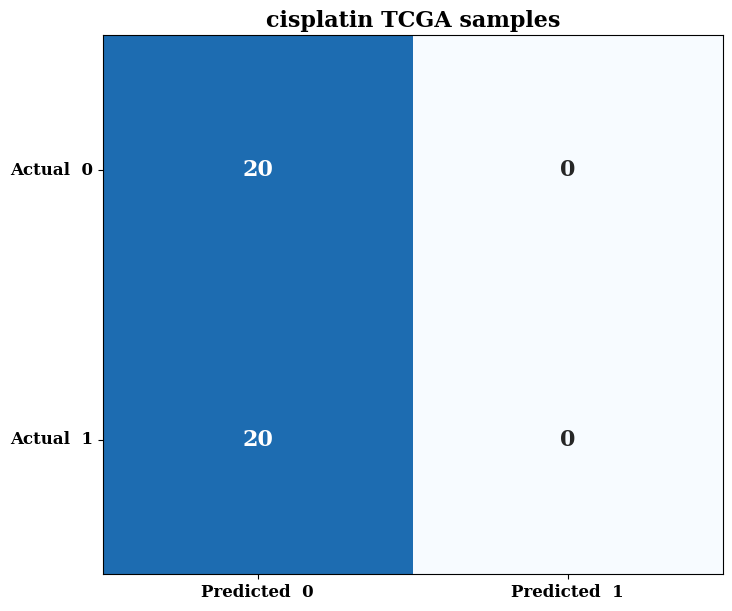

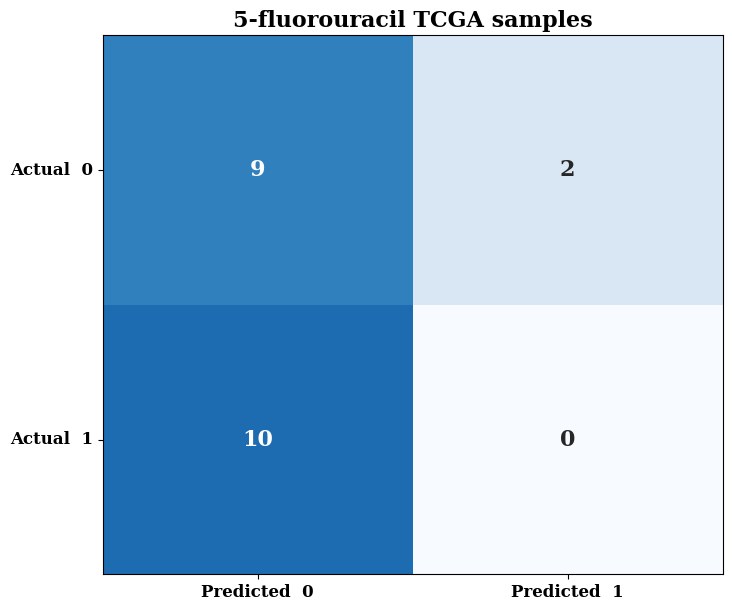

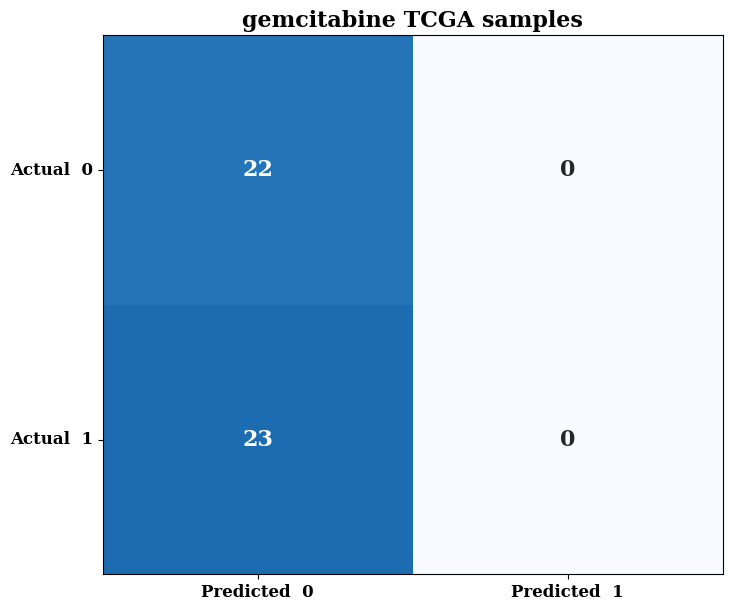

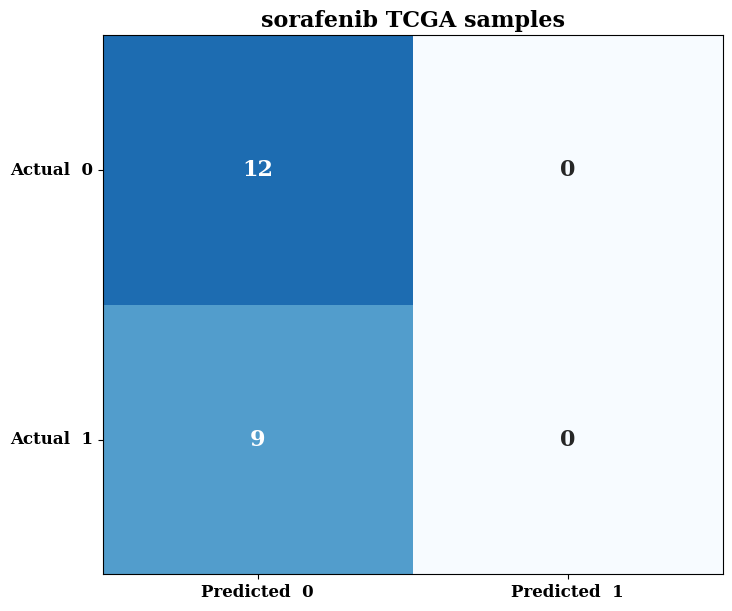

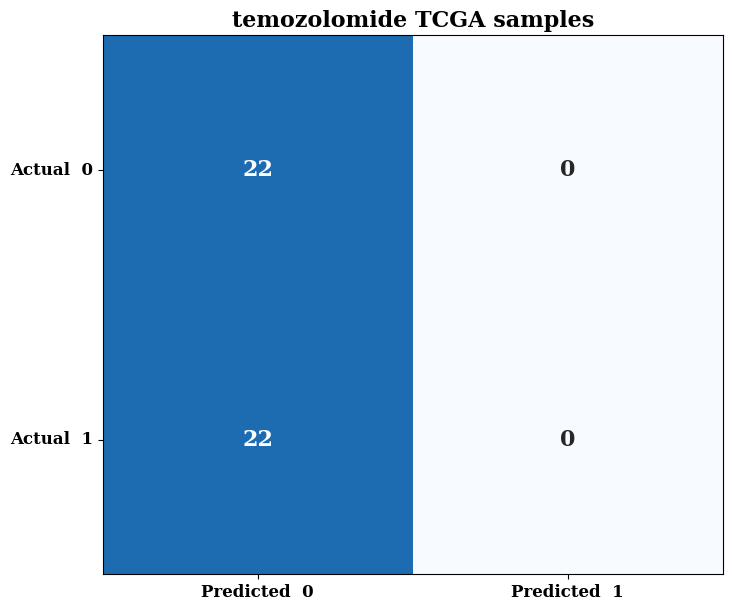

In [ ]:
if model_inference is True:
    set_seed(seed)
    if model_name == "Omics_DrugESPF_Model":
        model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                            drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                            n_layer, deconfound_EXPembedding, TCGA_pretrain_weight_path_dict= None)
    elif model_name == "Omics_DCSA_Model":
        model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                            drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                            n_layer, deconfound_EXPembedding, TCGA_pretrain_weight_path_dict= None)
    model.to(device=device)
    model.load_state_dict(BF_best_weight) 

    drug_list=["cisplatin", "5-fluorouracil", "gemcitabine", "sorafenib", "temozolomide"]
    drugs_metrics={}
    for drug_name in drug_list:
        if deconfound_EXPembedding is True:
            with open(f"../data/DAPL/share/pretrain/{DA_Folder}/{cohort}/{drug_name}_latent_results.pkl", 'rb') as f:
                latent_dict = pickle.load(f)
                CohortExp_df = pd.DataFrame(latent_dict).T # 32
        else:
            CohortExp_df = pd.read_csv(f"../data/DAPL/share/{cohort}_fromDAPL/{drug_name}/{cohort.lower()}data{geneNUM}.csv", sep=',', index_col=0) #1426
        label_df = pd.read_csv(f"../data/DAPL/share/{cohort}_fromDAPL/{drug_name}/{cohort.lower()}label{geneNUM}.csv", sep=',', index_col=0)
        # label_df = 1 - label_df # make label 0 to 1, 1 to 0 to match regressionpredicted output. after that 0: sensitive, 1: resistant
        CohortExp_df = CohortExp_df.sort_index(axis=0).sort_index(axis=1)
        print(f"{cohort}exp {drug_name}data",CohortExp_df.shape)
        label_df = label_df.sort_index(axis=0).sort_index(axis=1)
        print(f"label_df {drug_name}data",label_df.shape)
        for omic_type in include_omics:
            if deconfound_EXPembedding is True:
                omics_data_dict["Exp"] = CohortExp_df
            else:
                if omic_type == "Exp":
                    scaler = scaler_dict[omic_type]
                    omics_data_dict[omic_type] = pd.DataFrame(scaler.transform(CohortExp_df),index=CohortExp_df.index,columns=CohortExp_df.columns) # use fitted CCLE scaler to transform TCGA data
            omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
            omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]

            print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
            print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

#         drug_df_path= "../data/DAPL/share/GDSC_drug_merge_pubchem_dropNA_MACCS.csv"
        drug_df = pd.read_csv( drug_df_path, sep=',')
        # get specific drug and ccl
        drug_df = drug_df[drug_df['name'].str.lower() == drug_name.lower()]
        if ESPF is True:
            drug_smiles =drug_df["SMILES"] # 
            print("drug_smiles",drug_smiles)
            drug_names =drug_df.index
            # 挑出重複的SMILES
            duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
            #ESPF
            vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
            sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency
            # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
            drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
            drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)
        else:
            drug_encode = drug_df["MACCS166bits"]
            drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
            print("MACCS166bits_drug_encode_list type: ")# ,type(drug_encode_list))
            # Convert your data to tensors if they're in numpy
            drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
        #--------------------------------------------------------------------------------------------------------------------------
        num_ccl = list(omics_data_tensor_dict.values())[0].shape[0]
        num_drug = drug_encode.shape[0]
        print("num_ccl,num_drug: ",num_ccl,num_drug)

        response_matrix_tensor = torch.tensor(label_df.values, dtype=torch.float32).to(device).unsqueeze(1)
        # print(omics_data_tensor_dict)
        print(drug_features_tensor.shape)# Fc1c[nH]c(=O)[nH]c1=O 
        print(response_matrix_tensor.shape)

        if 'weighted' in criterion.loss_type :    
            if 'BCE' in criterion.loss_type :
                weighted_threshold = None
                total_samples = (~np.isnan(AUC_df.values)).sum().item()
                fewWt_samples = (AUC_df.values == 0).sum().item()
                moreWt_samples = (AUC_df.values == 1).sum().item()
                few_weight = total_samples / (2 * fewWt_samples)  
                more_weight = total_samples / (2 * moreWt_samples) 
            else:
                # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
                weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
                total_samples = (~np.isnan(AUC_df.values)).sum().item()
                fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
                moreWt_samples = total_samples - fewWt_samples
                few_weight = total_samples / (2 * fewWt_samples)  
                more_weight = total_samples / (2 * moreWt_samples)   
        else:
            weighted_threshold = None
            few_weight = None
            more_weight = None

        set_seed(seed)
        dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)
        onedrug_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        # eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
        (eval_targets, eval_outputs,predAUCwithUnknownGT,
        AttenScorMat_DrugSelf ,AttenScorMat_DrugCellSelf,
        eval_outputs_before_final_activation_list,  
        mean_batch_eval_loss_WO_penalty)  = evaluation(model, None,None,
                                                    criterion, onedrug_loader, device,ESPF,Drug_SelfAttention, 
                                                    weighted_threshold, few_weight, more_weight, 
                                                    outputcontrol='inference')
        # Calculate classification metrics                                            
        drugs_metrics[drug_name], _  = metrics_calculator(torch.cat(eval_targets), torch.cat(eval_outputs), BF_best_prob_threshold, metric, dataset="test")
        drugs_metrics[drug_name]["eval_targets"]=eval_targets
        drugs_metrics[drug_name]["eval_outputs"]=eval_outputs
        drugs_metrics[drug_name]["eval_outputs_before_final_activation_list"]=eval_outputs_before_final_activation_list
        drugs_metrics[drug_name][criterion.loss_type] = mean_batch_eval_loss_WO_penalty

        if 'BCE' in criterion.loss_type :
            (test_cm ,  test_GT_0_count, test_GT_1_count, 
            test_pred_binary_0_count, test_pred_binary_1_count ) =metrics_calculator.confusion_matrix(torch.cat(eval_targets), torch.cat(eval_outputs), BF_best_prob_threshold)

            drugs_metrics[drug_name]["CM"] = test_cm
            # # plot confusion matrix
            cm_datas = [(test_cm, cohort, 'Blues')]
            Confusion_Matrix_plot(cm_datas,hyperparameter_folder_path=hyperparameter_folder_path,drug=drug_name)

        else:#regression use prob_threshold to get binary outcome
            df = pd.DataFrame({'predicted AUDRC': torch.cat(eval_outputs).cpu().numpy(),
                    'Label': torch.cat(eval_targets).cpu().numpy()})
            # Perform t-test between the two groups
            sensitive = df[df['Label'] == 1]['predicted AUDRC']
            resistant = df[df['Label'] == 0]['predicted AUDRC']
            t_stat, p_val = ttest_ind(sensitive, resistant)
            drugs_metrics[drug_name]["pvalue"]= p_val
            if p_val<=0.05:
                TCGA_predAUDRC_box_plot_twoClass(drug_name,cohort,df,sensitive,resistant,p_val,hyperparameter_folder_path)
        # not a reasonable way to calculate AUROC and AUPRC to explain the model performance
           
            
    
    output_file = f"{hyperparameter_folder_path}/BF{BF}_{cohort}_inference_result.txt"
    with open(output_file, "w") as file:
        if 'BCE' in criterion.loss_type :
            for drug_name, metrics in drugs_metrics.items():
                file.write(f"\n{drug_name}\n")
                file.write(f"BF_best_prob_threshold: {BF_best_prob_threshold} according to {metric}\n")
                file.write(f"  test {criterion.loss_type}loss: {metrics[criterion.loss_type].item():.6f}\n")
                for key in metrics_type_set:
                    file.write(f"  '{key}': {metrics[key].item():.4f}\n")
                for key in ["eval_targets","eval_outputs_before_final_activation_list","eval_outputs"]:
                    file.write(f"\n{key}\n{metrics[key][0][:20]}\n\n")
        else:
            for drug_name, metrics in drugs_metrics.items():
                file.write(f"{drug_name}\n")
                file.write(f"  test {criterion.loss_type}loss: {metrics[criterion.loss_type].item():.6f}\n")
                if metrics['pvalue'].item() <= 0.05:
                    file.write(f"\n pvalue <= 0.05 ")
                else:
                    file.write(f"\n pvalue > 0.05 ")
                file.write(f"{drug_name} pvalue: {metrics['pvalue'].item():.4f}\n\n")
                for key in ["eval_targets","eval_outputs_before_final_activation_list","eval_outputs"]:
                    file.write(f"\n{key}\n{metrics[key][0][:20]}\n")
                        
                    
    os.chmod(output_file, 0o444)
    del model
    torch.cuda.set_device("cuda:0")# Set the current device
    gc.collect()# Optionally, force garbage collection to release memory 
    torch.cuda.empty_cache() # Empty PyTorch cache